# First analysis of geographical data

For performance reasons only may data is used.

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium import plugins
from folium.plugins import HeatMap

In [69]:
may_data = pd.read_csv("may_data.csv", parse_dates=["start_time","end_time"])
may_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363319 entries, 0 to 363318
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Unnamed: 0          363319 non-null  int64         
 1   start_time          363319 non-null  datetime64[ns]
 2   end_time            363319 non-null  datetime64[ns]
 3   start_station_id    363319 non-null  int64         
 4   end_station_id      363319 non-null  int64         
 5   start_station_name  363319 non-null  object        
 6   end_station_name    363319 non-null  object        
 7   bike_id             363319 non-null  int64         
 8   user_type           363319 non-null  object        
 9   Month               363319 non-null  int64         
 10  duration            363319 non-null  object        
 11  day                 363319 non-null  int64         
dtypes: datetime64[ns](2), int64(6), object(4)
memory usage: 33.3+ MB


In [70]:
unique_start_stations = pd.Series(may_data["start_station_name"].unique())
unique_end_stations = pd.Series(may_data["end_station_name"].unique())
print("Unique start stations: {}".format(len(unique_start_stations)))
print("Unique end stations: {}".format(len(unique_end_stations)))

Unique start stations: 474
Unique end stations: 475


In [71]:
print(unique_end_stations[unique_end_stations.apply(lambda x: not(x in unique_start_stations))])

0        Halsted St & Maxwell St
1       Loomis St & Lexington St
2         Michigan Ave & 18th St
3             May St & Taylor St
4             Daley Center Plaza
                 ...            
470       State St & Pershing Rd
471    Kedzie Ave & Roosevelt Rd
472      Wentworth Ave & 63rd St
473         Halsted St & 69th St
474       Lawndale Ave & 23rd St
Length: 475, dtype: object


In [72]:
start_count = may_data["start_station_name"].value_counts()
end_count = may_data["end_station_name"].value_counts()
print(start_count.head())
print("-----------------")
print(end_count.head())

Streeter Dr & Grand Ave       9488
Theater on the Lake           6044
Lake Shore Dr & Monroe St     5986
Lake Shore Dr & North Blvd    5519
Michigan Ave & Oak St         4348
Name: start_station_name, dtype: int64
-----------------
Streeter Dr & Grand Ave       10823
Theater on the Lake            6484
Lake Shore Dr & North Blvd     6019
Lake Shore Dr & Monroe St      5694
Michigan Ave & Oak St          4620
Name: end_station_name, dtype: int64


<BarContainer object of 50 artists>

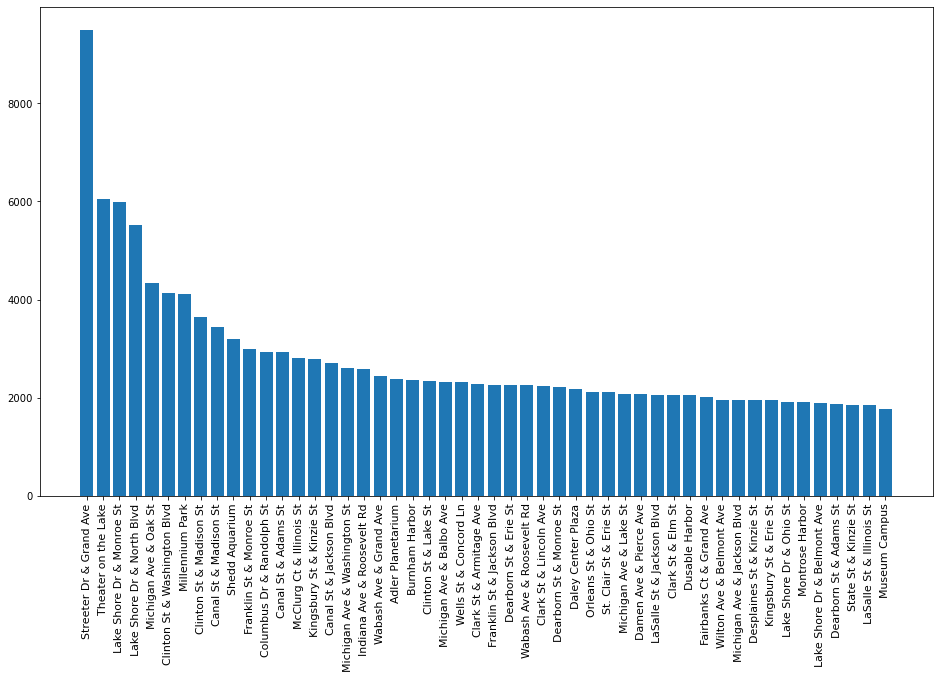

In [73]:
fig, ax = plt.subplots(figsize=[16,9])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90, fontsize="11")
ax.bar(start_count.index.to_series().iloc[:50],start_count.iloc[:50])

In [74]:
coordinates = pd.read_csv("../Divvy_Stations_2016_Q1Q2.csv")
coordinates.head()

,id,name,latitude,longitude,dpcapacity,online_date
0,456,2112 W Peterson Ave,41.991178,-87.683593,15,5/12/2015
1,101,63rd St Beach,41.781016,-87.576120,23,4/20/2015
2,109,900 W Harrison St,41.874675,-87.650019,19,8/6/2013
3,21,Aberdeen St & Jackson Blvd,41.877726,-87.654787,15,6/21/2013
4,80,Aberdeen St & Monroe St,41.880456,-87.653929,19,6/26/2013


In [83]:
loc_map = folium.Map(location=(41.873222041337044, -87.62596070777431),tiles='OpenStreetMap',zoom_start=12, control_scale=True, max_zoom=20)

In [89]:
start_coordinates = start_count.to_frame().merge(coordinates,left_on=start_count.index,right_on="name")
start_coordinates["coordinates"] = list(zip(start_coordinates["latitude"],start_coordinates["longitude"]))
start_coordinates = start_coordinates.rename(columns={"start_station_name":"started_tours"})
start_coordinates

,started_tours,id,name,latitude,longitude,dpcapacity,online_date,coordinates
0,9488,35,Streeter Dr & Grand Ave,41.892278,-87.612043,47,8/5/2013,"(41.892278000000005, -87.612043)"
1,6044,177,Theater on the Lake,41.926277,-87.630834,23,8/13/2013,"(41.926277, -87.630834)"
2,5986,76,Lake Shore Dr & Monroe St,41.880958,-87.616743,39,6/24/2013,"(41.880958, -87.616743)"
3,5519,268,Lake Shore Dr & North Blvd,41.911722,-87.626804,39,9/12/2013,"(41.911722, -87.626804)"
4,4348,85,Michigan Ave & Oak St,41.900960,-87.623777,23,6/21/2013,"(41.90096, -87.623777)"
...,...,...,...,...,...,...,...,...
457,6,386,Halsted St & 56th St,41.792930,-87.644990,15,4/15/2015,"(41.79293, -87.64499)"
458,6,393,Calumet Ave & 71st St,41.765508,-87.616918,15,4/21/2015,"(41.765508000000004, -87.616918)"
459,5,431,Eberhart Ave & 61st St,41.784142,-87.613308,15,4/20/2015,"(41.784141999999996, -87.61330799999999)"
460,5,384,Halsted St & 51st St,41.801832,-87.645214,15,4/15/2015,"(41.801832, -87.645214)"


In [91]:
for row in start_coordinates["coordinates","started_tours"]:
    folium.CircleMarker(radius=row["started_tours"], location=row["coordinates"], popup='The Waterfront', color='crimson', fill_color='crimson').add_to(loc_map)
#loc_map.add_child(plugins.HeatMap(start_coordinates["coordinates"], radius=10))
loc_map

KeyError: ('coordinates', 'started_tours')